In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Specify the path to your insurance_claims_raw file
df = pd.read_excel('C:/Users/Nekhavg/Desktop/Advanced_Features_Claims_Data.xlsx')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,Summer Claims,total_premiums_paid,net_value_of_customer,season_encoded,Season_Claim_Interaction,insured_education_level_encoded,insured_occupation_encoded,Education_Premium_Interaction,Occupation_Claim_Interaction,Age_Vehicles_Interaction
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,NaN,38455.540000,-33154.460000,1,71610,4,2,5627.64,143220,48
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,NaN,22747.180000,17677.180000,1,5070,4,6,4788.88,30420,42
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NaN,15780.063333,-18869.936667,1,34650,6,11,8478.84,381150,87
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NaN,30202.453333,-33197.546667,1,63400,6,1,8494.44,63400,41
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NaN,30094.290000,23594.290000,1,6500,0,11,0.00,71500,44


C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

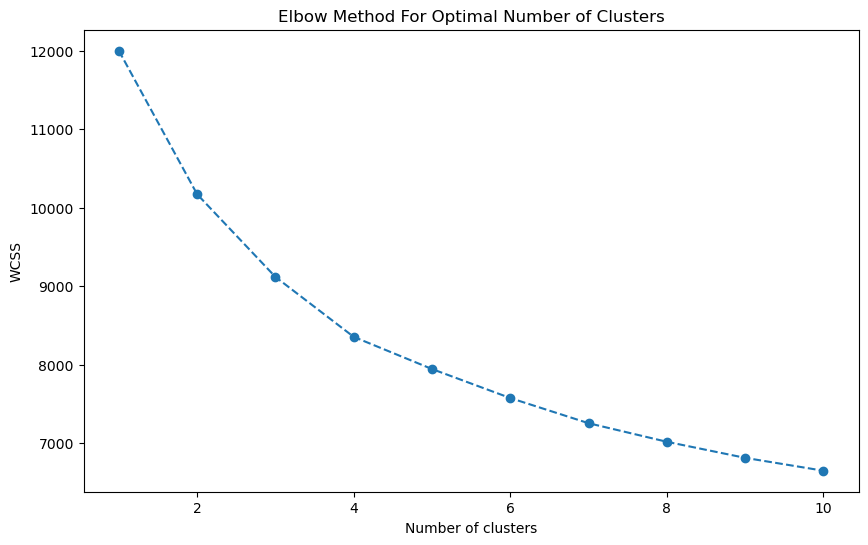

C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


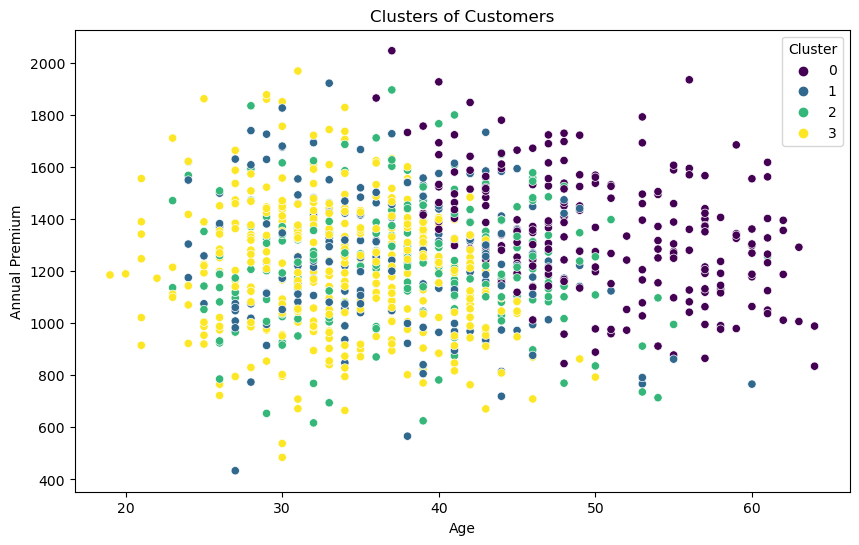

TypeError: agg function failed [how->mean,dtype->object]

In [17]:

# Data Cleaning and Preprocessing
# Handling missing values (example: fill missing values with a placeholder)
df.fillna(0, inplace=True)

# Convert date columns to datetime
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

# Drop rows where date conversion failed
df.dropna(subset=['policy_bind_date', 'incident_date'], inplace=True)

# Extract features from date columns
df['policy_bind_year'] = df['policy_bind_date'].dt.year
df['incident_year'] = df['incident_date'].dt.year

# Encode categorical variables
label_encoders = {}
categorical_columns = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 
                       'insured_occupation', 'insured_hobbies', 'insured_relationship', 
                       'incident_type', 'collision_type', 'authorities_contacted', 'incident_state', 
                       'incident_city', 'incident_location', 'auto_make', 'auto_model', 'fraud_reported']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Feature Engineering: Creating interaction terms and categories (example for a few interactions)
df['Age_Premium_Interaction'] = df['age'] * df['policy_annual_premium']
df['Claim_Deductible_Interaction'] = df['total_claim_amount'] * df['policy_deductable']

# Selecting features for clustering
features = ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 
            'umbrella_limit', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 
            'number_of_vehicles_involved', 'total_claim_amount', 'Age_Premium_Interaction', 
            'Claim_Deductible_Interaction']

# Check if all selected features exist in the dataframe
missing_features = [feature for feature in features if feature not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in the dataset: {missing_features}")

X = df[features]

# Ensure the dataframe is not empty
if X.empty:
    raise ValueError("The feature dataframe is empty. Check the preprocessing steps.")

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determining the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Applying K-Means with the optimal number of clusters
optimal_clusters = 4  # Suppose we determine 4 is the optimal number from the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster assignments to the original dataframe
df['Cluster'] = clusters

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='policy_annual_premium', hue='Cluster', data=df, palette='viridis')
plt.title('Clusters of Customers')
plt.xlabel('Age')
plt.ylabel('Annual Premium')
plt.show()

# Analyzing the clusters
cluster_profiles = df.groupby('Cluster').mean()
print(cluster_profiles)

# Saving the clustered data
df.to_csv('clustered_customers.csv', index=False)


Cluster Profiles (Numeric):
         months_as_customer        age  policy_number  policy_state  \
Cluster                                                               
0                341.094828  49.939655  560261.193966      1.034483   
1                179.176471  36.930481  566865.780749      1.026738   
2                187.889908  37.747706  541987.788991      0.995413   
3                138.716253  33.719008  529203.338843      1.005510   

         policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
Cluster                                                                         
0          0.939655         943.965517            1352.318405    1.185345e+06   
1          1.037433        1096.256684            1248.980267    1.385027e+06   
2          0.949541        2000.000000            1236.954404    1.013761e+06   
3          0.914601         754.820937            1212.259945    9.531680e+05   

           insured_zip  insured_sex  ...  net_value_of_cus

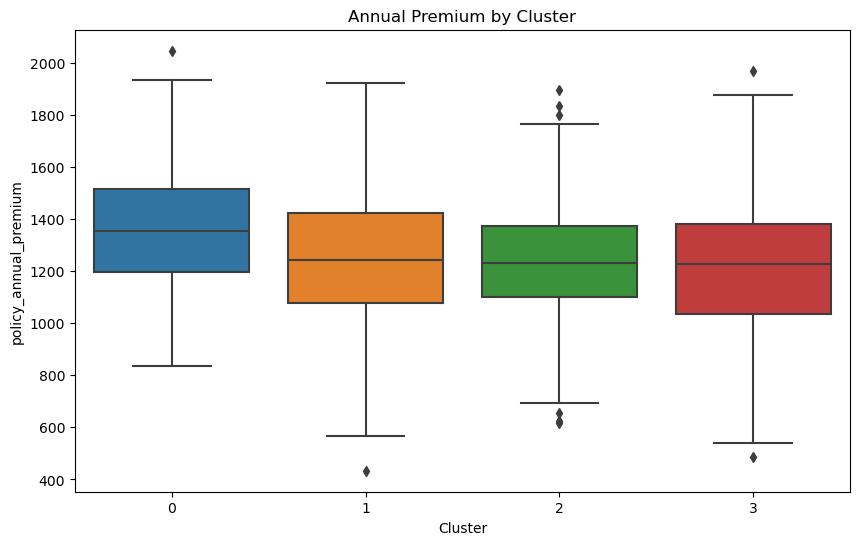

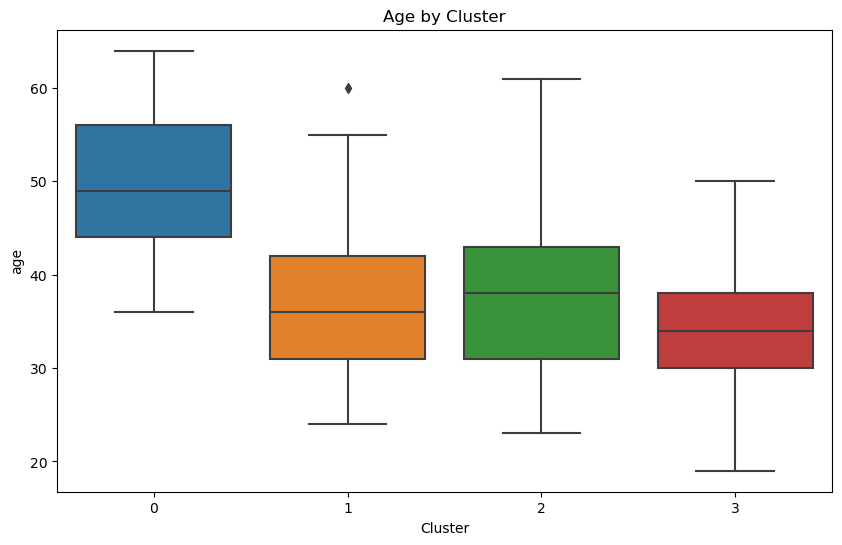

C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Nekhavg\AppData\Local\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



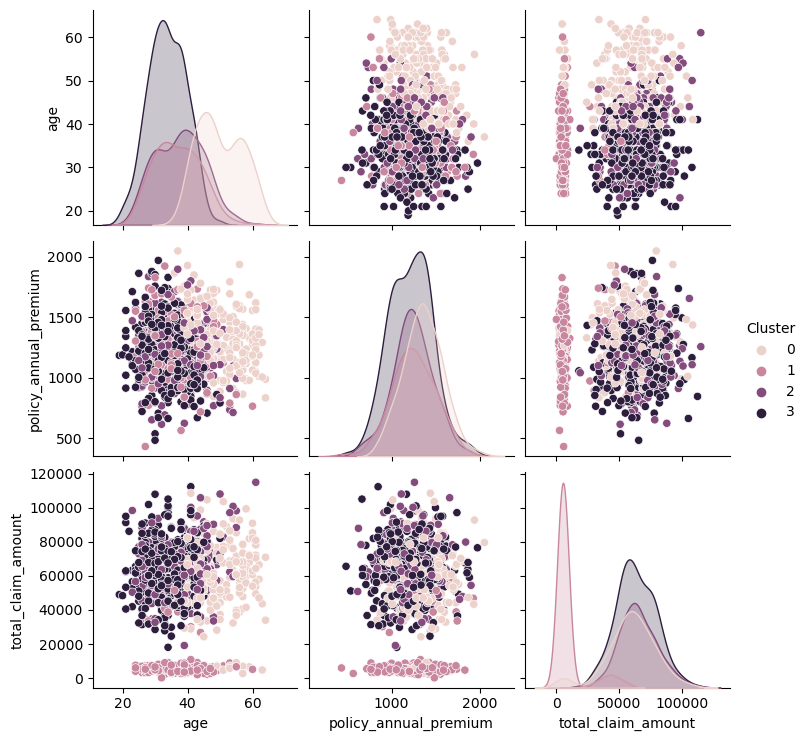

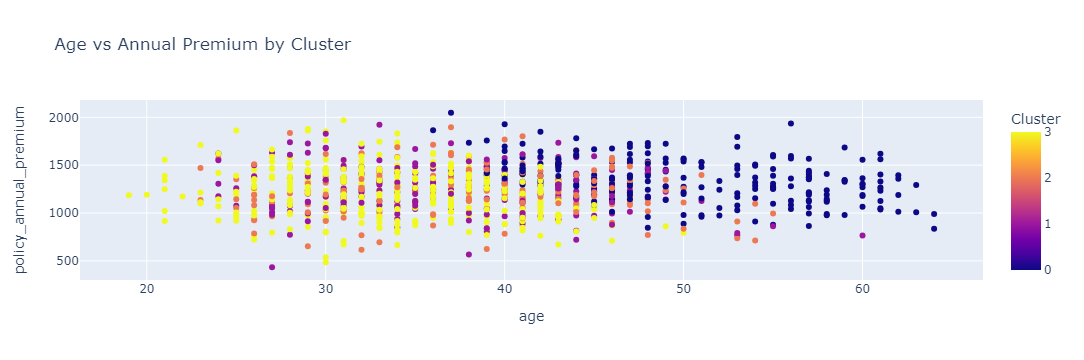

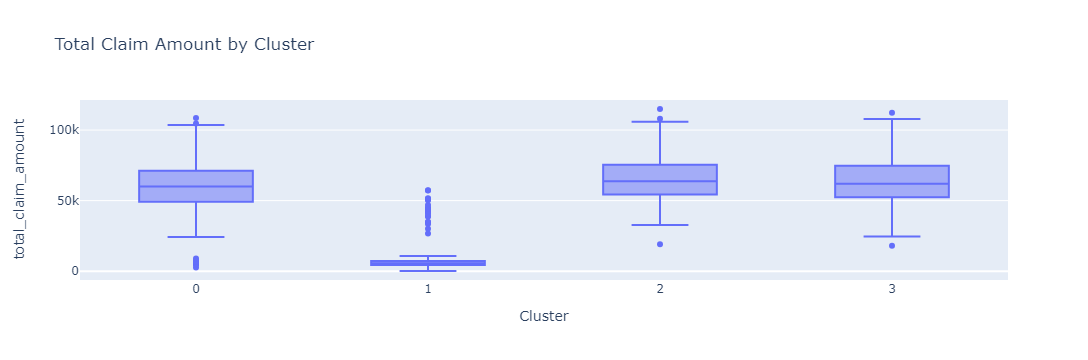

In [21]:

# Step 1: Selecting Numeric Columns
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

# Ensuring 'Cluster' is included for grouping
if 'Cluster' not in numeric_columns:
    numeric_columns.append('Cluster')

# Step 2: Group by Cluster and Calculate Mean for Numeric Columns
cluster_profiles_numeric = df[numeric_columns].groupby('Cluster').mean()
print("Cluster Profiles (Numeric):")
print(cluster_profiles_numeric)

# Step 3: Analyzing Categorical Columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Removing 'Cluster' from categorical columns if it is there
if 'Cluster' in categorical_columns:
    categorical_columns.remove('Cluster')

# Calculating the mode (most common value) for categorical columns
print("Cluster Profiles (Categorical):")
for column in categorical_columns:
    mode_df = df.groupby('Cluster')[column].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    print(f"Mode for {column} in each cluster:")
    print(mode_df)
    print("\n")

# Step 4: Visualizing Cluster Characteristics
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='policy_annual_premium', data=df)
plt.title('Annual Premium by Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='age', data=df)
plt.title('Age by Cluster')
plt.show()

# Pair plot for more detailed visualization
sns.pairplot(df, hue='Cluster', vars=['age', 'policy_annual_premium', 'total_claim_amount'])
plt.show()

# Scatter plot for age vs annual premium colored by cluster
import plotly.express as px

fig = px.scatter(df, x='age', y='policy_annual_premium', color='Cluster', title='Age vs Annual Premium by Cluster')
fig.show()

# Box plot for total claim amount by cluster
fig = px.box(df, x='Cluster', y='total_claim_amount', title='Total Claim Amount by Cluster')
fig.show()

# Step 5: Saving the Clustered Data
df.to_csv('clustered_customers.csv', index=False)


In [22]:
# Example profiles
cluster_profiles = {
    0: "Young customers, low annual premium, few claims",
    1: "Middle-aged customers, moderate annual premium, moderate claims",
    2: "Older customers, high annual premium, many claims",
    3: "Diverse age group, varied premiums and claims"
}

# Example targeted strategy
for cluster, profile in cluster_profiles.items():
    if cluster == 0:
        print(f"Cluster {cluster}: {profile}")
        print("Strategy: Offer discounts or entry-level policies to attract younger customers.")
    elif cluster == 1:
        print(f"Cluster {cluster}: {profile}")
        print("Strategy: Provide value-added services and moderate premium policies.")
    elif cluster == 2:
        print(f"Cluster {cluster}: {profile}")
        print("Strategy: Focus on premium policies with extensive coverage.")
    elif cluster == 3:
        print(f"Cluster {cluster}: {profile}")
        print("Strategy: Create flexible plans catering to diverse needs.")


Cluster 0: Young customers, low annual premium, few claims
Strategy: Offer discounts or entry-level policies to attract younger customers.
Cluster 1: Middle-aged customers, moderate annual premium, moderate claims
Strategy: Provide value-added services and moderate premium policies.
Cluster 2: Older customers, high annual premium, many claims
Strategy: Focus on premium policies with extensive coverage.
Cluster 3: Diverse age group, varied premiums and claims
Strategy: Create flexible plans catering to diverse needs.


In [23]:
import pandas as pd
import numpy as np

# Assuming 'df' is your original DataFrame and 'clusters' is the array of cluster labels
df['Cluster'] = clusters

# Function to calculate mode
def calculate_mode(series):
    return series.mode()[0]

# Group by clusters and calculate mean for numeric features
cluster_summary = df.groupby('Cluster').agg({
    'months_as_customer': 'mean',
    'age': 'mean',
    'policy_deductable': 'mean',
    'policy_annual_premium': 'mean',
    'umbrella_limit': 'mean',
    'capital-gains': 'mean',
    'capital-loss': 'mean',
    'total_claim_amount': 'mean',
    'injury_claim': 'mean',
    'property_claim': 'mean',
    'vehicle_claim': 'mean'
}).reset_index()

# Adding mode for categorical features
categorical_features = ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 
                        'insured_occupation', 'insured_hobbies', 'insured_relationship', 
                        'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted',
                        'incident_state', 'incident_city', 'incident_location', 'property_damage', 
                        'police_report_available', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported']

for feature in categorical_features:
    mode_series = df.groupby('Cluster')[feature].apply(calculate_mode)
    cluster_summary[feature] = mode_series.values

# Display the summary table
pd.set_option('display.max_columns', None)
print(cluster_summary)



   Cluster  months_as_customer        age  policy_deductable  \
0        0          341.094828  49.939655         943.965517   
1        1          179.176471  36.930481        1096.256684   
2        2          187.889908  37.747706        2000.000000   
3        3          138.716253  33.719008         754.820937   

   policy_annual_premium  umbrella_limit  capital-gains  capital-loss  \
0            1352.318405    1.185345e+06   25550.862069 -26183.189655   
1            1248.980267    1.385027e+06   21981.818182 -25589.839572   
2            1236.954404    1.013761e+06   26905.045872 -29546.788991   
3            1212.259945    9.531680e+05   25406.060606 -26150.688705   

   total_claim_amount  injury_claim  property_claim  vehicle_claim  \
0        59289.633621   8290.560345     8158.879310   42867.844828   
1         9602.834225   1360.909091     1252.245989    6989.679144   
2        65327.500000   9388.715596     9640.733945   46360.091743   
3        63349.366391   8842.0110